<a href="https://colab.research.google.com/github/khaoula-kplr/Generative-IA/blob/main/3.GAN/DCGAN/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧱 DCGAN - Bricks Data


> ### **!!! Attention :**

> #### **Avant de commencer le workshop, uploader les fichiers joignants au notebook dans le repository github "Generative IA"**


* L'objectif principal de notre workshop sur les Réseaux Générateurs Antagonistes (GAN) en utilisant le dataset "bricks" est d'explorer comment cette technologie de pointe peut être appliquée de manière créative et innovante dans le domaine de la génération d'images.

* Nous utiliserons l'ensemble de données "Images of LEGO Bricks" qui est disponible sur Kaggle. Il s'agit d'une collection d'images photographiques de 40 000 images de 50 briques de jouet différentes, générées par ordinateur et prises sous différents angles.



## **Code**

* Commencez par l'importation des différentes librairies que vous aurez besoin à savoir : Numpy, Matplotlib, et bien sur Tensorflow et Keras.

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from utils import display, sample_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [ ]:
# Configuration des paramètres pour l'entraînement de votre modèle GAN.
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. Prepare the data <a name="prepare"></a>

* Nous utilisons la fonction Keras image_dataset_from_directory pour créer un ensemble de données TensorFlow pointant vers le répertoire où les images sont stockées.

* Cela nous permet de lire des lots d'images en mémoire uniquement lorsque cela est nécessaire (par exemple, pendant l'entraînement), ce qui nous permet de travailler avec de grands ensembles de données sans nous soucier de devoir charger l'ensemble du jeu de données en mémoire.

* Il redimensionne également les images en 64 × 64 pixels, en interpolant entre les valeurs de pixel lorsque cela est nécessaire.

In [ ]:
# préparer et charger les données d'entraînement du modèle.
train_data = utils.image_dataset_from_directory(
    "/content/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 2733 files belonging to 1 classes.


* Les données originales sont mises à l'échelle dans la plage [0, 255] pour indiquer l'intensité des pixels.

* Lorsque nous entraînons des GAN, nous remettons à l'échelle les données dans la plage [-1, 1] afin de pouvoir utiliser la fonction d'activation tanh sur la couche finale du générateur.

* La fonction tanh a tendance à fournir des gradients plus forts que la fonction sigmoïde, ce qui peut être bénéfique pour l'apprentissage.

In [ ]:
# Définition d'une fonction de prétraitement pour normaliser et remodeler les images.

def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [ ]:
# Affichez quelques images de l'ensemble d'entraînement.
train_sample = sample_batch(train)

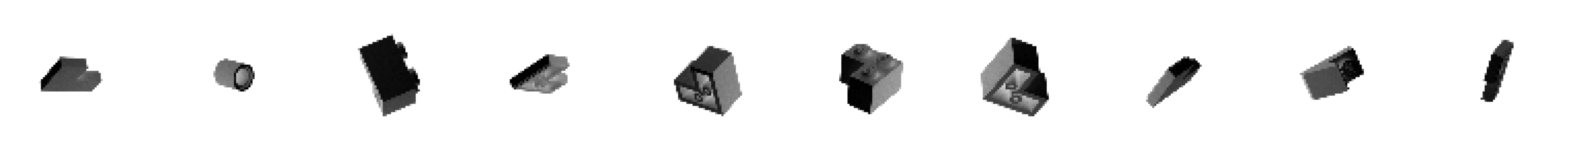

In [ ]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

* L'objectif du discriminateur est de prédire si une image est réelle ou fausse.

* Il s'agit d'un problème de classification d'image supervisée, nous pouvons donc utiliser une architecture similaire à celles des couches de convolution empilées, avec une seule sortie (un seul neurone).

In [ ]:
# Définir la couche d'entrée du discriminateur (l'image).
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
) # Empiler des couches Conv2D les unes sur les autres, en insérant des couches de BatchNormalization, d'activation LeakyReLU et de Dropout entre elles.
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x) # Applatir la dernière couche de convolution. À ce stade, la forme du tenseur est de 1 × 1 × 1, il n'est donc pas nécessaire d'ajouter une couche Dense finale.

discriminator = models.Model(discriminator_input, discriminator_output) # Créer le modèle Keras qui définit le discriminateur. Ce modèle prend en entrée une image et produit en sortie un seul nombre compris entre 0 et 1.

discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                             

* Maintenant, construisons le générateur. L'entrée du générateur sera un vecteur tiré d'une distribution normale multivariée standard.

* La sortie sera une image de la même taille qu'une image de l'ensemble de données d'entraînement d'origine.

* Cette description peut vous rappeler le décodeur d'un autoencodeur variationnel (VAE). En fait, le générateur d'un GAN remplit exactement le même rôle que le décodeur d'un VAE : convertir un vecteur de l'espace latent en une image.

* Le concept de mappage de l'espace latent vers le domaine d'origine est très courant dans la modélisation générative, car il nous donne la capacité de manipuler des vecteurs dans l'espace latent pour changer des caractéristiques de haut niveau des images dans le domaine d'origine.

In [ ]:
# Définir la couche d'entrée du générateur - un vecteur de longueur 100.
generator_input = layers.Input(shape=(Z_DIM,))

# Utiliser une couche Reshape pour obtenir un tenseur de forme 1 × 1 × 100, ce qui permettra d'appliquer des opérations de convolution transpose.
x = layers.Reshape((1, 1, Z_DIM))(generator_input)

x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x) # Passez ce tenseur à travers quatre couches Conv2DTranspose, en insérant des couches de BatchNormalization et de LeakyReLU entre elles.

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x) # La dernière couche Conv2DTranspose utilise une fonction d'activation tanh pour transformer la sortie dans la plage [-1, 1], afin de correspondre au domaine d'images d'origine.

# Le modèle Keras qui définit le générateur est un modèle qui accepte un vecteur de longueur 100 en entrée et produit un tenseur de forme [64, 64, 1] en sortie.
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

### **Explication**

Comme nous l'avons vu, les architectures du générateur et du discriminateur dans un DCGAN sont très simples et ne diffèrent pas tellement des modèles VAE. La clé pour comprendre les GAN réside dans la compréhension du processus d'entraînement du générateur et du discriminateur.

* Nous pouvons entraîner le discriminateur en créant un ensemble d'entraînement où certaines images sont des observations réelles de l'ensemble d'entraînement et d'autres sont des sorties fictives du générateur.

* Nous traitons ensuite cela comme un problème d'apprentissage supervisé, où les étiquettes sont de 1 pour les images réelles et de 0 pour les images générées, avec la perte de cross-entropy binaire comme fonction de perte.

Comment devons-nous entraîner le générateur ?

* Nous devons trouver un moyen d'évaluer chaque image générée afin qu'il puisse s'optimiser vers des images bien évaluées.
* Heureusement, nous avons un discriminateur qui fait exactement cela ! Nous pouvons générer un lot d'images et les faire passer par le discriminateur pour obtenir un score pour chaque image.

* La fonction de perte pour le générateur est alors simplement la cross-entropy binaire entre ces probabilités et un vecteur de uns, car nous voulons entraîner le générateur à produire des images que le discriminateur pense être réelles.

### **Code**

Keras nous permet de créer une fonction de train_step personnalisée pour implémenter cette logique.

In [ ]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy() # La fonction de perte pour le générateur et le discriminateur est BinaryCrossentropy.
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        ) # Pour entraînez le réseau, on commence par échantillonner un lot de vecteurs à partir d'une distribution normale multivariée standard.

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            ) # Ensuite, faites passer ces vecteurs à travers le générateur pour produire un lot d'images générées.
            real_predictions = self.discriminator(real_images, training=True) # Maintenant, demandez au discriminateur de prédire l'authenticité du lot d'images réelles...
            fake_predictions = self.discriminator(
                generated_images, training=True
            ) # ... et du lot d'images générées.

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0 # La perte du discriminateur est la moyenne de la cross-entropy binaire sur les images réelles (avec l'étiquette 1) et les images générées (avec l'étiquette 0).

            g_loss = self.loss_fn(real_labels, fake_predictions) # La perte du générateur est la cross-entropy binaire entre les prédictions du discriminateur pour les images générées et une étiquette de 1.

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        ) # Mettez à jour les poids du discriminateur et du générateur séparément.
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
# Créez le DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [ ]:
# Vérification de la condition LOAD_MODEL pour décider si le modèle doit être chargé depuis un point de contrôle.

if LOAD_MODEL:
    #  Charge les poids d'un modèle préalablement sauvegardé depuis le chemin spécifié.
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [ ]:
# Compiler le DCGAN
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [ ]:
# Configuration d'un callback pour sauvegarder les poids du modèle à chaque fin d'époque.
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)
# Configuration d'un callback pour enregistrer des journaux TensorBoard pour la visualisation de l'entraînement.

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Définition d'une classe de callback personnalisée pour générer des images à la fin de chaque époque.

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        # Génération de vecteurs de bruit aléatoires dans l'espace latent du modèle.

        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )

        # Génération d'images en utilisant le modèle générateur.
        generated_images = self.model.generator(random_latent_vectors)

        # Normalisation des images générées.
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()

        # Affichage et sauvegarde des images générées dans le répertoire "output".
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),

        )


mkdir: cannot create directory ‘/output’: File exists


In [ ]:
# Lancement de l'entraînement du modèle DCGAN avec des paramètres spécifiques et des callbacks.

dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [ ]:
# Sauvegardez les modèles
generator.save("./models/generator")
discriminator.save("./models/discriminator")

## 3. Generate new images <a name="decode"></a>

In [ ]:
# Échantillonnez quelques points dans l'espace latent à partir de la distribution normale standard.
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Décodez les points échantillonnés.
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 1s 573ms/step


In [ ]:
# Tracez un graphique des images décodées.
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Affichez la grille d'images.
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
# Pour le tester, nous pouvons trouver l'image de l'ensemble d'entraînement qui est la plus proche d'un exemple généré particulier.
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 [==============================] - 0s 212ms/step


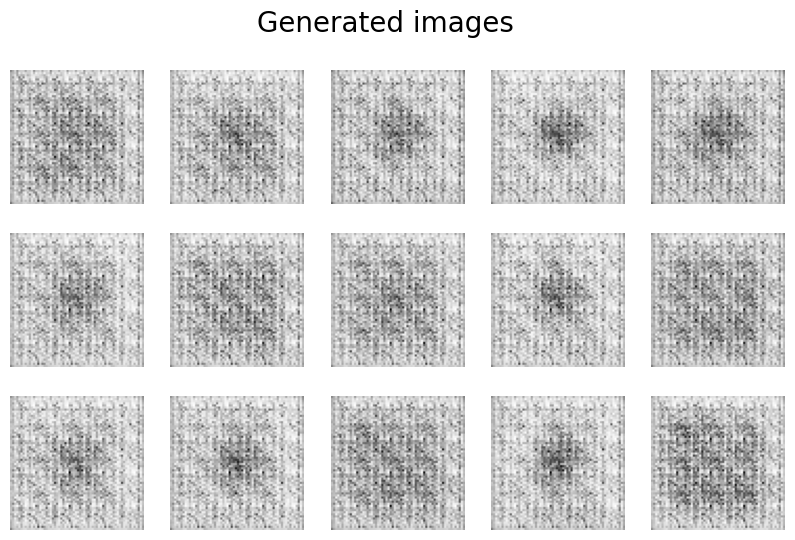

In [ ]:
# Afficher les images générées par le modèle
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

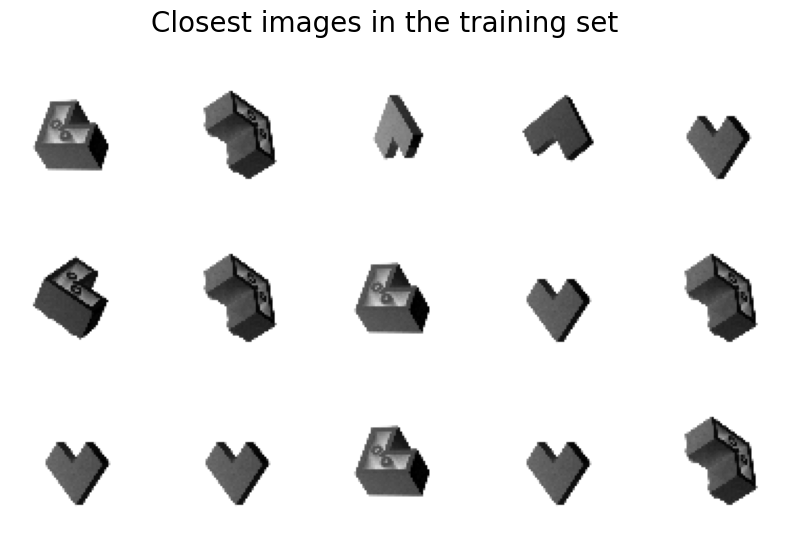

In [ ]:
# Trouver les images les plus semblables à celles qui sont générées dans le dataset d'entrainement
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()